In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:

# Carregar os dados
r_cols = ['user_id', 'movie_id', 'rating']
ratings = pd.read_csv('data.csv', sep='\t', names=r_cols, usecols=range(3))

m_cols = ['movie_id', 'title']
movies = pd.read_csv('item.csv', sep='|', names=m_cols, usecols=range(2), encoding='ISO-8859-1')

ratings = pd.merge(movies, ratings)

In [9]:

# Filtrar filmes populares (com pelo menos 100 avaliações)
movie_stats = ratings.groupby('title').agg({'rating': ['size', 'mean']})
popular_movies = movie_stats['rating']['size'] >= 100
filtered_ratings = ratings[ratings['title'].isin(movie_stats[popular_movies].index)]

# Criar a tabela dinâmica de ratings
userRatings = filtered_ratings.pivot_table(index=['user_id'], columns=['title'], values=['rating'])

# Calcular a matriz de correlação usando o método de Spearman
corrMatrix = userRatings.corr(method='spearman', min_periods=100)

In [10]:

# Função para recomendar filmes
def recommend_movies(user_id, num_recommendations=10):
    myRatings = userRatings.loc[user_id].dropna()
    simCandidates = pd.Series()
    
    for i in range(0, len(myRatings.index)):
        sims = corrMatrix[myRatings.index[i]].dropna()
        sims = sims.map(lambda x: x * myRatings[i])
        simCandidates = simCandidates._append(sims)
    
    simCandidates = simCandidates.groupby(simCandidates.index).sum()
    simCandidates.sort_values(inplace=True, ascending=False)
    
    filteredSims = simCandidates.drop(myRatings.index)
    filteredSims = filteredSims[filteredSims > 0]  # Excluir filmes com similaridade negativa
    
    return filteredSims.head(num_recommendations)


In [11]:
# Exemplo de recomendação para o usuário 0
top_recommendations = recommend_movies(0)
print("Top recomendações para o usuário 0:")
print(top_recommendations)

Top recomendações para o usuário 0:
(rating, Return of the Jedi (1983))                    6.583598
(rating, Raiders of the Lost Ark (1981))               4.634162
(rating, Indiana Jones and the Last Crusade (1989))    3.459717
(rating, Sting, The (1973))                            3.328747
(rating, Field of Dreams (1989))                       3.082816
(rating, Batman (1989))                                3.012647
(rating, Jaws (1975))                                  2.986981
(rating, Back to the Future (1985))                    2.985774
(rating, Singin' in the Rain (1952))                   2.952571
(rating, E.T. the Extra-Terrestrial (1982))            2.937272
dtype: float64


C:\Users\daneil\AppData\Local\Temp\ipykernel_4304\3933085869.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sims = sims.map(lambda x: x * myRatings[i])
C:\Users\daneil\AppData\Local\Temp\ipykernel_4304\3933085869.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  simCandidates = simCandidates._append(sims)
C:\Users\daneil\AppData\Local\Temp\ipykernel_4304\3933085869.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

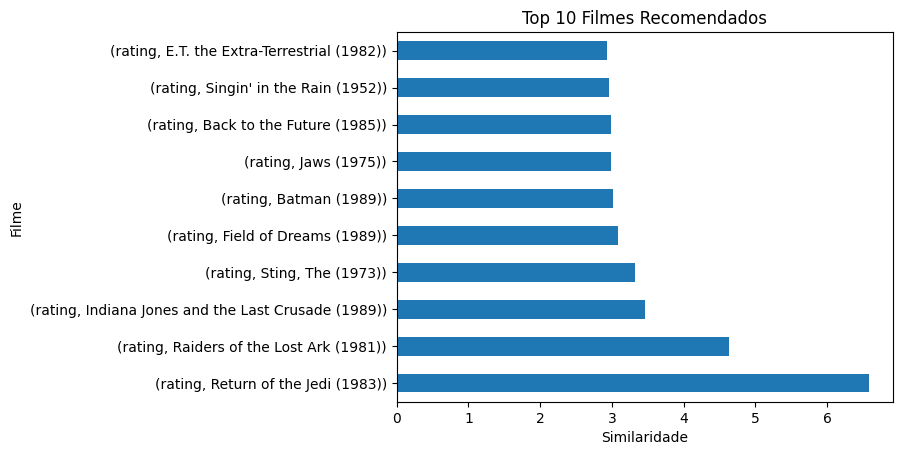

In [12]:






# Visualizar as recomendações
top_recommendations.plot(kind='barh')
plt.title('Top 10 Filmes Recomendados')
plt.xlabel('Similaridade')
plt.ylabel('Filme')
plt.show()